In [43]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm

In [45]:
import bnn.data
import bnn.functions
import bnn.layer
import bnn.loss
import bnn.network
import bnn.optimizer

## Get data

In [64]:
root='./data'
download=True
batch_size=int(2**11)
shuffle=True
include_last_if_uneven=True
binarise_thesh=0.5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_MNIST_loader = bnn.data.MNISTDataLoader(
    root=root,
    download=download,
    train=True,
    batch_size=batch_size,
    shuffle=shuffle,
    include_last_if_uneven=include_last_if_uneven,
    binarise_thresh=binarise_thesh,
)
test_MNIST_loader = bnn.data.MNISTDataLoader(
    root=root,
    download=download,
    train=False,
    batch_size=batch_size,
    shuffle=shuffle,
    include_last_if_uneven=include_last_if_uneven,
    binarise_thresh=binarise_thesh,
)

In [65]:
for batch_id, datum in enumerate(tqdm.tqdm(test_MNIST_loader)):
    if batch_id == 0:
        print(batch_id)
        print(torch.max(datum.input))
        print(torch.min(datum.input))
        print(datum.target)

 80%|████████  | 4/5 [00:00<00:00, 16.84it/s]

0
tensor(1, dtype=torch.int32)
tensor(-1, dtype=torch.int32)
tensor([[-1, -1,  1,  ..., -1, -1, -1],
        [-1, -1, -1,  ..., -1, -1, -1],
        [-1, -1, -1,  ..., -1, -1, -1],
        ...,
        [-1, -1, -1,  ...,  1, -1, -1],
        [ 1, -1, -1,  ..., -1, -1, -1],
        [-1, -1, -1,  ..., -1, -1, -1]], dtype=torch.int32)


100%|██████████| 5/5 [00:00<00:00, 17.89it/s]


In [66]:
len(test_MNIST_loader), len(train_MNIST_loader)

(5, 30)

## Load Model

In [67]:
import glob
import pathlib
import pickle

import numpy as np

In [68]:
import bnn.save
import bnn.compress

In [69]:
checkpoint_folder = pathlib.Path.home() / 'tmp' / 'checkpoints'

#checkpoint_name = 'olive-puddle-78'
checkpoint_name = 'vital-mountain-102'

folder = checkpoint_folder / checkpoint_name

In [70]:
with open(folder / 'schema', 'rb') as f:
    schema = pickle.load(f)

In [71]:
checkpoints = sorted(glob.glob(str(folder) + '/*.npz'))

checkpoint = pathlib.Path(checkpoints[-1])
checkpoint

PosixPath('/home/blustrini/tmp/checkpoints/vital-mountain-102/chkpt_epoch_004500.npz')

In [72]:
bWs = np.load(checkpoint)

In [73]:
TBNN = bnn.compress.make_network_from_schema_and_bWs(schema=schema, bWs=bWs)
TBNN

TernBinNetwork(
  (layers): ModuleDict(
    (TernBinLayer0): W: Parameter containing:
    tensor([[ 1,  1, -1,  ..., -1,  0,  0],
            [ 1,  0, -1,  ...,  0,  1,  1],
            [-1,  1, -1,  ...,  1,  1,  0],
            ...,
            [-1,  1, -1,  ...,  1,  0,  0],
            [ 1, -1, -1,  ...,  1,  0,  0],
            [ 1,  1,  0,  ..., -1,  1,  0]], dtype=torch.int32)
    (TernBinLayer1): W: Parameter containing:
    tensor([[-1, -1,  0,  ...,  0,  0, -1],
            [ 0,  0,  0,  ...,  1,  1, -1],
            [ 0, -1, -1,  ...,  0, -1,  0],
            ...,
            [ 1,  0,  0,  ...,  0,  1, -1],
            [-1, -1, -1,  ...,  1,  0,  1],
            [ 1,  0,  1,  ..., -1,  1,  1]], dtype=torch.int32)
    (TernBinLayer2): W: Parameter containing:
    tensor([[-1,  0,  0,  ...,  1,  0, -1],
            [ 1, -1, -1,  ..., -1, -1,  0],
            [ 0,  1,  0,  ...,  0,  0,  1],
            ...,
            [ 0, -1, -1,  ...,  1,  0,  1],
            [-1,  1,  0,  .

In [74]:
TBNN.to(device)
train_MNIST_loader.to(device)
test_MNIST_loader.to(device)

In [75]:
num_correct = 0
total = test_MNIST_loader._datapoints
for batch_id, batch in enumerate(tqdm.tqdm(test_MNIST_loader)):
    # forward pass and loss
    output_unproj = TBNN.forward_no_proj(batch.input)
    output_argmax = torch.argmax(output_unproj, dim=-1)
    target_argmax = torch.argmax(batch.target, dim=-1)

    num_correct += torch.sum(target_argmax == output_argmax)

print(f"accuracy: {num_correct / total}")

100%|██████████| 5/5 [00:00<00:00, 14.90it/s]

accuracy: 0.7594000101089478


In [76]:
input_ims = batch.input.cpu().reshape(-1, 28, 28)
input_class = target_argmax.cpu()
output_class = output_argmax.cpu()

input_class.shape

torch.Size([1808])

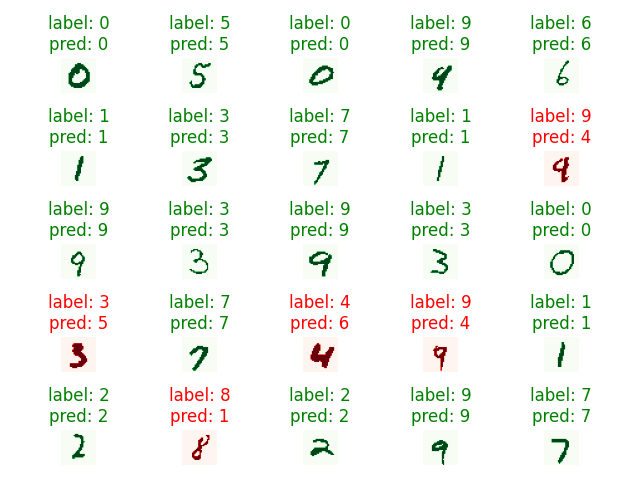

In [77]:
FIG_NAME = "preds"
plt.close(FIG_NAME)

num_plots = 25
ceil_sqrt_num_plots = np.ceil(np.sqrt(num_plots)).astype(int)

fig, axs = plt.subplots(ceil_sqrt_num_plots, ceil_sqrt_num_plots, num=FIG_NAME)
axs = np.array(axs).flatten()

for ax, in_im, in_cls, out_cls in zip(axs, input_ims, input_class, output_class):
    if in_cls == out_cls:
        c = "green"
        cmap = 'Greens'
    else:
        c = "red"
        cmap = 'Reds'
    ax.imshow(in_im, cmap=cmap)
    ax.set_title(f'label: {in_cls}\npred: {out_cls}', color=c)
    ax.axis('off')

fig.tight_layout()

plt.show()

In [78]:
k = 3
ins = torch.topk(output_unproj, k=k, dim=-1).indices
out = torch.zeros_like(output_argmax, dtype=bool)
for i in range(k):
    out |= ins[..., i] == target_argmax

torch.sum(out) / len(out)

tensor(0.9375, device='cuda:0')

In [79]:
import bnn.metrics

ds: list[bnn.random.DISCRETE_DIST | None] = []
for n, p in TBNN.named_parameters():
    if "W" in n:
        d = bnn.metrics.distribution(p.cpu())
        ds.append(d)

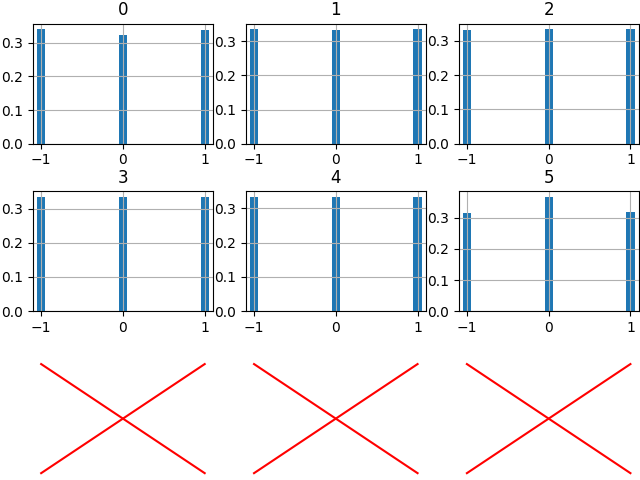

In [80]:
FIG_NAME = "dist"
plt.close(FIG_NAME)

num_plots = len(ds)
ceil_sqrt_num_plots = np.ceil(np.sqrt(num_plots)).astype(int)

fig, axs = plt.subplots(ceil_sqrt_num_plots, ceil_sqrt_num_plots, num=FIG_NAME)
axs = np.array(axs).flatten()

min_x, max_x = -1, 1
width=0.1
for i, (ax, d) in enumerate(zip(axs, ds + [None]*len(axs))):
    if d is None:
        ax.plot(np.linspace(min_x, max_x), np.linspace(0, 1), '-', color="red")
        ax.plot(np.linspace(max_x, min_x), np.linspace(0, 1), '-', color="red")
        ax.axis("off")

    else:
        ax.set_title(i)
        vals = [pair.value for pair in d]
        probs = [pair.probability for pair in d]

        if len(vals) > 3:
            ax.plot(vals, probs, 'o-')
        else:
            ax.bar(vals, probs, width=width)

        min_x = min(min_x, min(vals))
        max_x = max(max_x, max(vals))

for ax in axs:
    ax.set_xlim(min_x-width, max_x+width)
    ax.grid()

fig.tight_layout(pad=0.1)
plt.show()

In [81]:
assert bnn.network.network_params_al_ternary(TBNN)